In [1]:
from ple.games.flappybird import FlappyBird
from ple import PLE
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, sgd
from keras.layers.normalization import BatchNormalization
import random
from IPython.display import clear_output
from datetime import datetime
import os
import glob
import shutil
import time
import matplotlib.pyplot as plt

couldn't import doomish
Couldn't import doom


Using TensorFlow backend.


In [10]:
start_time = time.time() #Utilisé pour regarder le temps écoulé lors de l'apprentissage


########################## Définition des paramètres, modifiables ####################################
epochs = 5000 #Nombre de parties à jouer
gamma = 0.99 # discount factor 0.99
alpha = 0.2 # learning rate 0.1
prob = 0.8 #proba de jouer None lors d'un mouvement aléatoire
experience_replay = False # Activer l'experience replay ? sûrement nécessaire pour meilleur apprentissage
batchSize = 32 # Taille du mini batch
buffer = 5000 #Taille du buffer
print_delay = 100
epsilon = 1 # Initialisation d'epsilon (exploration/exploitation) 0 pour desactiver l'explo aléatoire

# FAIRE ATTENTION AUX RECOMPENSES : Jouer peut être sur des récompenses à posteriori plutôt que ce dict
reward_dict = { "positive": 1, "negative": 0.0, "tick": 0, "loss": -1000.0, "win": 0.0} #values

######################################################################################################

##################################Choix de repartir de 0 ou charger un réseau entrainé ##################

# model = load_model('./log-files/31-01-2018-15:11:14/FlappyBird.dqf')

# Création du réseau de neurones
model = Sequential()
# # Première couche, 150 avec 8 inputs, les 8 composantes du vecteur d'état
# model.add(Dense(150, kernel_initializer='lecun_uniform', input_shape=(8,)))
# Première couche, 150 avec 4 inputs, les 4 composantes du vecteur d'état qu'on a choisis
model.add(Dense(150, kernel_initializer='lecun_uniform', input_shape=(4,)))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=1))
# # Couche cachée, taille 300
# model.add(Dense(300, kernel_initializer='lecun_uniform'))
# model.add(Activation('relu'))
# Couche cachée, taille 150
model.add(Dense(150, kernel_initializer='lecun_uniform'))
model.add(Activation('relu'))
# Couche de sortie, taille 2 comme les 2 actions
model.add(Dense(2, kernel_initializer='lecun_uniform'))
model.add(Activation('linear'))
# Compilation du modèle
model.compile(loss='mse', optimizer="rmsprop")

##########################################################################################################


# Définition des fonctions utilisées et initialisation des variables

def getstate(jeu): #On ne prend que les éléments 0,1,2,3 : vitesse, pos verticale et horizontale de l'oiseau
                                                          #et pos verticale du haut du prochain tuyau
    a= list(jeu.getGameState().values())[0:4]
    norm_y = a[0]/300
    norm_speed = a[1]/16
    norm_x = a[2]/283
    norm_top_next_y = a[3]/256
    if norm_y>1 or norm_speed >1 or norm_x>1 or norm_top_next_y >1:
        print(norm_y, norm_speed, norm_x, norm_top_next_y)
        print('raté')
        return 'raté'
    print(norm_y, norm_speed, norm_y, norm_top_next_y)
    return a

actions = [None, 119]
update=0
h=0 #Taille du vecteur buffer, initialisée à 0
replay = [] # vecteur de buffer initialisé vide

score = 0 # Variable utilisée pour mémoriser le meilleur score obtenu sur les epochs parties
time_for_save = datetime.now().strftime('%d-%m-%Y-%H:%M:%S') # Pour l'enregistrement
path = os.path.join('log-files', time_for_save)
os.makedirs(path) # Création du dossier
filenames = glob.glob('FlappyPolicy.ipynb') # Sauvegarde du fichier notebook utilisé pour générer le réseau
for filename in filenames:
    shutil.copy(filename, path)
    
# Variables utilisées pour voir l'évolution
scores = []
average = []
bests = []
games = []

#Initilisation du jeu "jeu" et du joueur "p"
jeu = FlappyBird()

#frame_skip = The number of times we skip getting observations while repeat an action
#num_steps = The number of times we repeat an action.
#force_fps = True pour ne pas jouer en temps réel (plus vite)
#display_screen = True pour afficher le déroulement de la partie en direct
#reward_values = This contains the rewards we wish to set give our agent

p = PLE(jeu, fps=30, frame_skip=1, num_steps=1, force_fps=True, display_screen=True, reward_values = reward_dict)

p.reset_game()

#Début des parties, on en joue un nombre : epochs
for i in range(epochs):
    #Réinitialisation du jeu
    p.reset_game()
    #Acquisition de l'état du jeu (s)
    state = getstate(jeu)
    
    #Début de la boucle, tant que la partie n'est pas finie :
    while(not jeu.game_over()):
        
        # Evaluation de la valeur de la policy pour les deux actions : Q(s,a)
        qval = model.predict(np.array(state).reshape(1,len(state)), batch_size=batchSize)
 
        #Stratégie Exploration/exploitation 
        if (np.random.random() < epsilon): # On choisit une action au hasard, proba prob pour l'action None
            if np.random.random() < prob:
                action = actions[0]
            else:
                action = actions[1]
        else: # On choisit la meilleure action, qui maximise qval (Q(s,a))
            if qval[0][0] > qval[0][1]:
                action = actions[0]
            else:
                action = actions[1]

        #On fait l'action "action" (a), on observe le nouvel état new_state (s') et la récompense reward (r)
        r = p.act(action)
        
        #On observe la récompense liée à cette action
        if r == 0: #Dans ce cas l'oiseau est encore en vie, on donne une récompense de 1
            reward = 1
        elif r == 1: #L'oiseau a franchi un tuyau, on donne une récompense de  100
            reward = 100
        else: #L'oiseau a touché un tuyau, le sol ou le plafond, on fait reward = r = -1000 (cf reward_dict)
            reward = r
            
        new_state = getstate(jeu)   
        
        #Actualisation du score si meilleur que le précédent
        if jeu.getScore() > score :
            score = jeu.getScore()
            
        if not experience_replay:# si on n'a pas activé la mémoire
            #Calcul des valeurs Q(s',a) POURQUOI BATCH SIZE ????
            newQ = model.predict(np.array(new_state).reshape(1,len(state)), batch_size=batchSize)
            # Recherche du max
            maxQ = np.max(newQ)
            #Initialisation de y à Q(s,a)
            y = np.zeros((1,2))
            y[:] = qval[:]
            
            #Calcul de l'update
            if reward != reward_dict["loss"]: # Partie pas perdue
                update = (reward + gamma * maxQ)
            else:
                update = reward
                
            # On met la valeur "update" dans la composante de y qui correspond à l'action jouée
            if action == None:
                y[0][0] = update #target output
            else :
                y[0][1] = update
                
            #On entraine le réseau de neurones avec state en entrée, y en sortie
            model.fit(np.array(state).reshape(1, len(state)), y, batch_size=batchSize, epochs=1, verbose=0)
            
            #On actualise l'état
            state = new_state
            
            #clear_output(wait=True)
            
        else: #Si on a activé la mémoire
            
            if (len(replay) < buffer): #Si le buffer n'est pas plein, on ajoute le dernier sars
                replay.append((state, action, reward, new_state))
            else: #Si il est plein, on remplace une vieille valeur et fait de l'apprentissage
                
                if (h < (buffer-1)): #Si h est plus petit que la taille du vecteur replay :
                    h += 1 #On incrémente h pour changer la composante suivante du vecteur replay
                else: #Sinon (donc si h pointe vers le dernier élément du replay)
                    h = 0 # On remet h à 0
                # On remplace l'élément h par le sars nouvellement acquis
                replay[h] = (state, action, reward, new_state)
                
                #On prends batchSize éléments aléatoirement dans notre replay memory :
                minibatch = random.sample(replay, batchSize)
                
                # Réinitialisation de X_train et y_train
                X_train = []
                y_train = []
                
                #On prend les éléments dans minibatch, le but est de remplir X_train et y_train
                for memory in minibatch: #On parcourt les éléments sélectionnés
                    #On cherche le max de Q(s',a) :
                    #On stocke s,a,r,s pour chaque élément
                    old_state, action, reward, new_state = memory
                    #On calcule la q_value pour l'ancien état s Q(s,.)
                    old_qval = model.predict(np.array(old_state).reshape(1,len(old_state)), batch_size=1)
                    #On calcule la q_value pour le nouvel état s' Q(s',.)
                    newQ = model.predict(np.array(new_state).reshape(1,len(new_state)), batch_size=1)
                    #On stocke la valeur maximale de la q_value du nouvel état max(a)Q(s',a)
                    maxQ = np.max(newQ)
                    # Initialisation de y aux valeurs de Q(s,.) de l'ancien état
                    y = np.zeros((1,2))
                    y[:] = old_qval[:]
                    
                    #Calcul de l'update en fonction de si l'état est terminal ou non
                    if reward != reward_dict["loss"]: #Etat non terminal
                        update = (reward + (gamma * maxQ))
                    else: #Etat terminal
                        update = reward
                    # On met la valeur "update" dans la composante de y qui correspond à l'action jouée
                    if action == None:
                        y[0][0] = update
                    else :
                        y[0][1] = update
                        
                    #On ajoute old_state et y à X_train et y_train
                    X_train.append(np.array(old_state).reshape(len(old_state),))
                    y_train.append(np.array(y).reshape(2,))
                    
                #On met X_train et y_train sous forme de tableau
                X_train = np.array(X_train)
                y_train = np.array(y_train)
                
                #Entrainement du réseau avec batchSize éléments
                model.fit(X_train, y_train, batch_size=batchSize, epochs=1, verbose=0)
                
                #Mise à jour de l'état avec le nouvel état
                state = new_state
            #clear_output(wait=True)
    
    #Après la fin de la partie, on ajoute le score final à la liste des scores
    scores.append(jeu.getScore()-reward_dict["loss"])
    
    # Mise à jour de la stratégie exploitation / exploration
    if epsilon > 0.2:
        epsilon -= (1.0/epochs)
    
        
    #Sauvegarde du Q courant, et affichage de quelques donnée pour suivre l'apprentissage
    if ((i+1)%print_delay) == 0:
        print("")
        print("Game #: %s" % (i+1,))
        print("Meilleur score sur les ",print_delay," derniers essais =", np.max(scores))
        print("Score moyen sur les ",print_delay," derniers essais =", np.mean(scores))
        elapsed_time = time.time() - start_time
        printime = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
        print("Temps écoulé : ", printime)
        average.append(np.mean(scores))
        bests.append(np.max(scores))
        games.append(i+1)
        print('Save done avec moyenne: ' + np.str(np.mean(scores)))
        scores = []
        now = datetime.now().strftime("%d-%m-%Y-%H:%M:%S")
        name = 'FlappyBird_'+now+'.dqf'
        dire = './log-files/'+time_for_save+'/'+name
        model.save(dire)
            
print("Best score =", score)
dire = './log-files/'+time_for_save+'/FlappyBird.dqf'
model.save(dire)

0.8533333333333334 0.0 0.8533333333333334 0.20703125
0.8266666666666667 -0.5 0.8266666666666667 0.20703125
0.8 -0.5 0.8 0.20703125
0.7766666666666666 -0.4375 0.7766666666666666 0.20703125
0.75 -0.5 0.75 0.20703125
0.7233333333333334 -0.5 0.7233333333333334 0.20703125
0.6966666666666667 -0.5 0.6966666666666667 0.20703125
0.67 -0.5 0.67 0.20703125
0.6466666666666666 -0.4375 0.6466666666666666 0.20703125
0.6266666666666667 -0.375 0.6266666666666667 0.20703125
0.6 -0.5 0.6 0.20703125
0.5733333333333334 -0.5 0.5733333333333334 0.20703125
0.5466666666666666 -0.5 0.5466666666666666 0.20703125
0.52 -0.5 0.52 0.20703125
0.49666666666666665 -0.4375 0.49666666666666665 0.20703125
0.4766666666666667 -0.375 0.4766666666666667 0.20703125
0.45 -0.5 0.45 0.20703125
0.42333333333333334 -0.5 0.42333333333333334 0.20703125
0.4 -0.4375 0.4 0.20703125
0.37333333333333335 -0.5 0.37333333333333335 0.20703125
0.3466666666666667 -0.5 0.3466666666666667 0.20703125
0.3233333333333333 -0.4375 0.3233333333333333 0

0.4166666666666667 0.0 0.4166666666666667 0.13671875
0.42 0.0625 0.42 0.13671875
0.4266666666666667 0.125 0.4266666666666667 0.13671875
0.4 -0.5 0.4 0.13671875
0.37333333333333335 -0.5 0.37333333333333335 0.13671875
0.35 -0.4375 0.35 0.13671875
0.33 -0.375 0.33 0.13671875
0.31333333333333335 -0.3125 0.31333333333333335 0.13671875
0.2866666666666667 -0.5 0.2866666666666667 0.13671875
0.26 -0.5 0.26 0.13671875
0.23333333333333334 -0.5 0.23333333333333334 0.13671875
0.20666666666666667 -0.5 0.20666666666666667 0.13671875
0.18333333333333332 -0.4375 0.18333333333333332 0.13671875
0.15666666666666668 -0.5 0.15666666666666668 0.13671875
0.15666666666666668 0.0 0.15666666666666668 0.13671875
0.16 0.0625 0.16 0.13671875
0.16666666666666666 0.125 0.16666666666666666 0.13671875
0.17666666666666667 0.1875 0.17666666666666667 0.13671875
0.19 0.25 0.19 0.13671875
0.20666666666666667 0.3125 0.20666666666666667 0.13671875
0.22666666666666666 0.375 0.22666666666666666 0.13671875
0.25 0.4375 0.25 0.136

0.06666666666666667 -0.25 0.06666666666666667 0.23046875
0.056666666666666664 -0.1875 0.056666666666666664 0.23046875
0.05 -0.125 0.05 0.23046875
0.04666666666666667 -0.0625 0.04666666666666667 0.23046875
0.04666666666666667 0.0 0.04666666666666667 0.23046875
0.02 -0.5 0.02 0.23046875
-0.006666666666666667 -0.5 -0.006666666666666667 0.23046875
-0.03 -0.4375 -0.03 0.23046875
0.8533333333333334 -0.4375 0.8533333333333334 0.359375
0.8033333333333333 -0.9375 0.8033333333333333 0.359375
0.7533333333333333 -0.9375 0.7533333333333333 0.359375
0.7066666666666667 -0.875 0.7066666666666667 0.359375
0.6633333333333333 -0.8125 0.6633333333333333 0.359375
0.6233333333333333 -0.75 0.6233333333333333 0.359375
0.5866666666666667 -0.6875 0.5866666666666667 0.359375
0.5533333333333333 -0.625 0.5533333333333333 0.359375
0.5266666666666666 -0.5 0.5266666666666666 0.359375
0.5266666666666666 0.0 0.5266666666666666 0.359375
0.53 0.0625 0.53 0.359375
0.5366666666666666 0.125 0.5366666666666666 0.359375
0.546

0.2633333333333333 -0.25 0.2633333333333333 0.47265625
0.25333333333333335 -0.1875 0.25333333333333335 0.47265625
0.24666666666666667 -0.125 0.24666666666666667 0.47265625
0.24333333333333335 -0.0625 0.24333333333333335 0.47265625
0.24333333333333335 0.0 0.24333333333333335 0.47265625
0.24666666666666667 0.0625 0.24666666666666667 0.47265625
0.22 -0.5 0.22 0.47265625
0.19333333333333333 -0.5 0.19333333333333333 0.47265625
0.17 -0.4375 0.17 0.47265625
0.15 -0.375 0.15 0.47265625
0.13333333333333333 -0.3125 0.13333333333333333 0.47265625
0.12 -0.25 0.12 0.47265625
0.11 -0.1875 0.11 0.47265625
0.10333333333333333 -0.125 0.10333333333333333 0.47265625
0.1 -0.0625 0.1 0.47265625
0.1 0.0 0.1 0.47265625
0.10333333333333333 0.0625 0.10333333333333333 0.47265625
0.11 0.125 0.11 0.47265625
0.12 0.1875 0.12 0.47265625
0.13333333333333333 0.25 0.13333333333333333 0.47265625
0.15 0.3125 0.15 0.47265625
0.12333333333333334 -0.5 0.12333333333333334 0.47265625
0.09666666666666666 -0.5 0.09666666666666

0.74 0.25 0.74 0.41015625
0.7566666666666667 0.3125 0.7566666666666667 0.41015625
0.7766666666666666 0.375 0.7766666666666666 0.41015625
0.8 0.4375 0.8 0.41015625
0.8266666666666667 0.5 0.8266666666666667 0.41015625
0.8 -0.5 0.8 0.41015625
0.8 0.0 0.8 0.41015625
0.8033333333333333 0.0625 0.8033333333333333 0.41015625
0.81 0.125 0.81 0.41015625
0.82 0.1875 0.82 0.41015625
0.8333333333333334 0.25 0.8333333333333334 0.41015625
0.8066666666666666 -0.5 0.8066666666666666 0.41015625
0.78 -0.5 0.78 0.41015625
0.7533333333333333 -0.5 0.7533333333333333 0.41015625
0.7266666666666667 -0.5 0.7266666666666667 0.41015625
0.7033333333333334 -0.4375 0.7033333333333334 0.41015625
0.6766666666666666 -0.5 0.6766666666666666 0.41015625
0.6766666666666666 0.0 0.6766666666666666 0.41015625
0.68 0.0625 0.68 0.41015625
0.6866666666666666 0.125 0.6866666666666666 0.41015625
0.6966666666666667 0.1875 0.6966666666666667 0.41015625
0.71 0.25 0.71 0.41015625
0.7266666666666667 0.3125 0.7266666666666667 0.41015625

ValueError: cannot reshape array of size 1 into shape (1,4)

In [5]:
help(FlappyBird)

Help on class FlappyBird in module ple.games.flappybird:

class FlappyBird(ple.games.base.pygamewrapper.PyGameWrapper)
 |  Used physics values from sourabhv's `clone`_.
 |  
 |  .. _clone: https://github.com/sourabhv/FlapPyBird
 |  
 |  
 |  Parameters
 |  ----------
 |  width : int (default: 288)
 |      Screen width. Consistent gameplay is not promised for different widths or heights, therefore the width and height should not be altered.
 |  
 |  height : inti (default: 512)
 |      Screen height.
 |  
 |  pipe_gap : int (default: 100)
 |      The gap in pixels left between the top and bottom pipes.
 |  
 |  Method resolution order:
 |      FlappyBird
 |      ple.games.base.pygamewrapper.PyGameWrapper
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, width=288, height=512, pipe_gap=100)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  game_over(self)
 |      Gets the status of the game, returns True if game has hit a termina

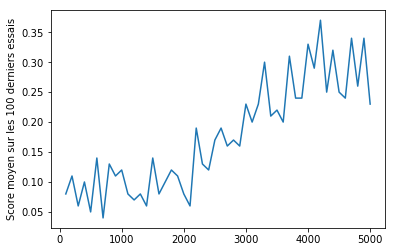

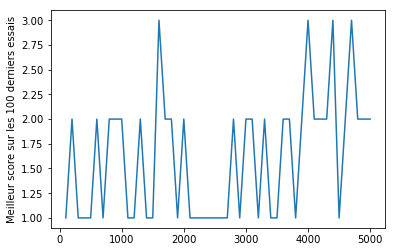

In [18]:
# Affichage des courbes des meilleurs scores et scores moyen lors des dernieres parties enregistrées
plt.plot(games,average)
plt.ylabel('Score moyen sur les 100 derniers essais')
plt.show()
plt.plot(games,bests)
plt.ylabel('Meilleur score sur les 100 derniers essais')
plt.show()

# Test du réseau de neurones

In [21]:
from keras.models import load_model
import numpy as np
actions = [None, 119]
model = load_model(dire)

def FlappyPolicy(state, screen):
	state_list = list(state.values())[0:4]
	
	qval = model.predict(np.array(state_list).reshape(1,len(state_list)), batch_size=1)
	if qval[0][0] > qval[0][1]:
	    action = actions[0]
	else:
	    action = actions[1]
	return action


game = FlappyBird()
p = PLE(game, fps=30, frame_skip=1, num_steps=1, force_fps=True, display_screen=True)

p.init()
reward = 0.0

nb_games = 100
cumulated = np.zeros((nb_games))

for i in range(nb_games):
    p.reset_game()
    
    while(not p.game_over()):
        state = game.getGameState()
        screen = p.getScreenRGB()
        action=FlappyPolicy(state, screen) ### Your job is to define this function.
        
        reward = p.act(action)
        cumulated[i] = cumulated[i] + reward
    print('Game #', i, ' score :',cumulated[i]+5)

average_score = np.mean(cumulated+5)
max_score = np.max(cumulated+5)

print("Score moyen sur les 100 parties :", average_score)
print("Score max sur les 100 parties :", max_score)

if average_score > 15:
    print("YOU WOOOOOOOOOOOOOOOOOOON !!!!!")
else:
    print("Loser.")
        


Game # 0  score : 0.0
Game # 1  score : 1.0
Game # 2  score : 0.0
Game # 3  score : 0.0
Game # 4  score : 0.0
Game # 5  score : 0.0
Game # 6  score : 0.0
Game # 7  score : 0.0
Game # 8  score : 1.0
Game # 9  score : 0.0
Game # 10  score : 0.0
Game # 11  score : 0.0
Game # 12  score : 0.0
Game # 13  score : 0.0
Game # 14  score : 0.0
Game # 15  score : 0.0
Game # 16  score : 0.0
Game # 17  score : 0.0
Game # 18  score : 0.0
Game # 19  score : 0.0
Game # 20  score : 0.0
Game # 21  score : 0.0
Game # 22  score : 0.0
Game # 23  score : 0.0
Game # 24  score : 0.0
Game # 25  score : 1.0
Game # 26  score : 0.0
Game # 27  score : 0.0
Game # 28  score : 0.0
Game # 29  score : 0.0
Game # 30  score : 0.0
Game # 31  score : 0.0
Game # 32  score : 0.0
Game # 33  score : 0.0
Game # 34  score : 1.0
Game # 35  score : 0.0
Game # 36  score : 0.0
Game # 37  score : 0.0
Game # 38  score : 0.0
Game # 39  score : 0.0
Game # 40  score : 0.0
Game # 41  score : 0.0
Game # 42  score : 1.0
Game # 43  score : 0.

'./log-files/31-01-2018-15:11:14/FlappyBird.dqf'